# Data Ted
## Analisi dei Ted Talk
---
#### Matano Francesco S5253162
#### Vassallo Edoardo S4965918 
---

# Introduzione ed Obiettivi
> ### Nel nostro progetto di Introduzione alla Data Science abbiamo deciso di studiare l'evoluzione nel tempo della popolarità dei video della piattaforma TED

# 0. Preparativi
> ## Librerie importate


In [120]:
##LIB FOR UTIL THING
import matplotlib.pyplot as plt 
import numpy as np
import re
##LIB FOR ML THING
import pandas as pd 
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime as dt

> ## Funzioni utilizzate per il notebook

In [121]:
def print_stats_field(df, field):
    print("--------------------------------------------"   )
    print("Statistiche relative a:  ", field               )
    print("--------------------------------------------"   )
    print("Media:                   ",  df[field].mean()   )
    print("Moda:                    ",  df[field].mode()[0])
    print("Mediana:                 ",  df[field].median() )
    print("Varianza:                ",  df[field].var()    )
    print("Deviazione standard:     ",  df[field].std()    ) 
    print("--------------------------------------------"   )

In [122]:
def print_all_olap_on_first_dim(olap_df, xlabel, ylabel, list_of_labels):

    cols = (len(list_of_labels) // 2) + 1

    plt.figure(figsize=(10, 15))

    for element in range(0, len(list_of_labels)):
        plt.subplot(cols, 2, element+1)
        plt.title(list_of_labels[element])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.imshow(olap_df[element, :, :])
        plt.colorbar()

        for (j,i),label in np.ndenumerate(olap_df[element, :, :]):
            plt.text(i,j,label,ha='center',va='center')

    plt.show()

In [123]:
def print_ttest_1samp(first_dataset, second_dataset, column, name):
    t, p_value = stats.ttest_1samp(first_dataset[column].values, second_dataset[column].mean())
    print("\nt-test on ", name, ":")
    print('Valore test: ', t)
    print('P-value: ', p_value)

def print_chi_squared(obs, exp, name):
    chi_squared, p_value = stats.chisquare(f_obs = film_recenti, f_exp = imdb_score_altri_servizi)
    print("\nt-test on ", name, ":")
    print('Chi-quadrato: ', chi_squared)
    print('P-value: ', p_value)

In [124]:
## Array globali creati per l'utilizzo all'interno del notebook
# theme_list     = ["climate", "COVID", "health", "war", "AI"]
quantize_date  = ['70\'s', '80\'s',    '90\'s',     '00\'s',   '10\'s',  '20\'s' ]
quantize_views = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '1M-20M', '>20M'  ]
quantize_likes = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '>1M'             ]

---

> ## Import Dataset

In [125]:
daTed = pd.read_csv("data_ted.csv")
daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


# 1. Pulizia Dati

Analizzando i nostri dati, abbiamo ritrovato i seguenti errori:

1. È presente una riga con autore mancante

In [126]:
print(daTed.loc[(daTed['author'].isnull())])

                   title author           date  views  likes  \
3039  Year In Ideas 2015    NaN  December 2015    532     15   

                                          link  
3039  https://ted.com/talks/year_in_ideas_2015  


2. Due delle righe presenti vengono erroneamente datati al gennaio 1970, data sospetta in quanto valore minimo dei timestamp UNIX. L'errore è stato verificato cercando i video in questione online

In [127]:
print(daTed.loc[(daTed['date'] == 'January 1970')])

                                 title          author          date   views  \
736               Innovations in sleep      Beautyrest  January 1970   60000   
738  Love letters to what we hold dear  Debbie Millman  January 1970  192000   

     likes                                               link  
736   1800  https://ted.com/talks/beautyrest_innovations_i...  
738   5700  https://ted.com/talks/debbie_millman_love_lett...  


Siccome questi errori riguardano solo un paio di righe, si è deciso di correggere le righe, invece che eliminarle, nel seguente modo:

1. Vedendo [il video in questione](https://www.ted.com/talks/year_in_ideas_2015) si è visto che si tratta di un video celebrativo realizzato dall'azienda stessa. Si è deciso quindi di attribuirlo a *"TED"*, 

In [128]:
daTed.loc[(daTed['author'].isnull()), 'author'] = 'TED'
print(daTed.loc[(daTed['author'].isnull())])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


2. Similmente, possiamo rintracciare la data di pubblicazione dei video online. *"Innovations in sleep"* è stato [caricato](https://youtu.be/mo264ECPacQ?si=O2mQA_2kww7flGm3) sulla pagina Youtube di TED nel Luglio 2020.  *"Love letters to what we hold dear"* è stato presentato nel corso di TED2020. Cercando la [scaletta](https://tedlive.ted.com/webcasts/t2020/session/419) dell'evento, scopriamo che è stato presentato nel Giugno di quell'anno 

In [129]:
daTed.loc[(daTed['title'] == 'Innovations in sleep'),              'date'] = 'July 2020'
daTed.loc[(daTed['title'] == 'Love letters to what we hold dear'), 'date'] = 'June 2020'

print(daTed.loc[(daTed['date'] == 'January 1970')])

Empty DataFrame
Columns: [title, author, date, views, likes, link]
Index: []


L'ultima correzione necessaria è al **formato delle date**. Al momento la data di pubblicazione è memorizzata come una stringa mese-anno. Decidiamo di tradurla nel tipo *datetime*, per aiutare in seguito 

In [130]:
daTed["date"] = pd.to_datetime(daTed['date'], format='%B %Y')

# 2. Visualizzazione dei dati

La nostra analisi si basa principalmente sullo studio dell'evoluzione temporale dei dati. Cominciamo quindi mostrando un grafico del numero di uscite rispetto all'anno

<Axes: title={'center': 'Numero di Video per Anno'}, xlabel='Anno', ylabel='N° Video'>

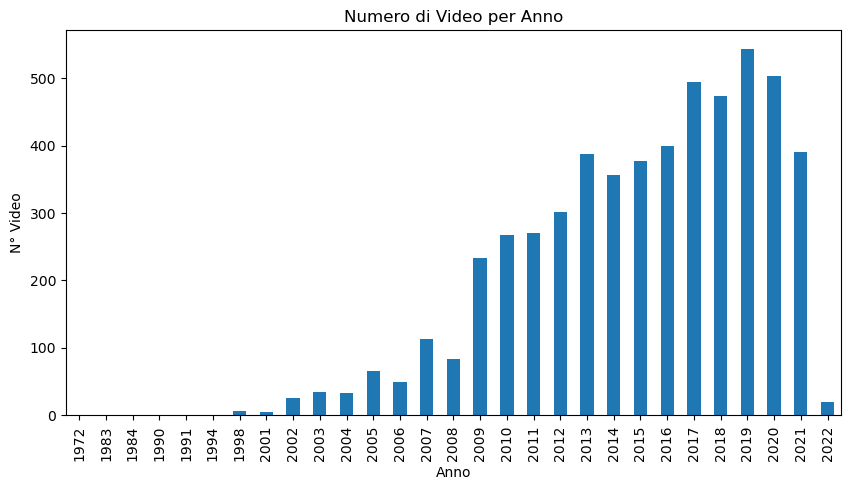

In [131]:
daTed.groupby(daTed.date.dt.year)['title'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Anno", 
                                                         title   = "Numero di Video per Anno" )

Possiamo quindi notare un *trend*, la crescita del numero di video nel corso degli anni

Vediamo ora di studiare la **qualità** di questi video, sulla base dei valori di like e visualizzazioni. Realizziamo a tal scopo, un **OLAP** ad hoc, **quantizzando** le colonne dei likes, views, e data di pubblicazione.

In [132]:
# Quantizzazione per decade
# p.s max date 2022

daTed.loc[daTed['date'].between(pd.to_datetime("1970", format='%Y'), pd.to_datetime("1979", format='%Y'), 'both'), 'date_quant'] = quantize_date[0]
daTed.loc[daTed['date'].between(pd.to_datetime("1980", format='%Y'), pd.to_datetime("1989", format='%Y'), 'both'), 'date_quant'] = quantize_date[1]
daTed.loc[daTed['date'].between(pd.to_datetime("1990", format='%Y'), pd.to_datetime("1999", format='%Y'), 'both'), 'date_quant'] = quantize_date[2]
daTed.loc[daTed['date'].between(pd.to_datetime("2000", format='%Y'), pd.to_datetime("2009", format='%Y'), 'both'), 'date_quant'] = quantize_date[3]
daTed.loc[daTed['date'].between(pd.to_datetime("2010", format='%Y'), pd.to_datetime("2019", format='%Y'), 'both'), 'date_quant'] = quantize_date[4]
daTed.loc[daTed['date'].between(pd.to_datetime("2020", format='%Y'), pd.to_datetime("2029", format='%Y'), 'both'), 'date_quant'] = quantize_date[5]

# Quantizzazione per quantità di views
## p.s. max views: 72M

daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
daTed.loc[daTed['views'].between(10000    , 99999   , 'both'), 'views_quant'] = quantize_views[1]
daTed.loc[daTed['views'].between(100000   , 499999  , 'both'), 'views_quant'] = quantize_views[2]
daTed.loc[daTed['views'].between(500000   , 999999  , 'both'), 'views_quant'] = quantize_views[3]
daTed.loc[daTed['views'].between(1000000  , 19999999, 'both'), 'views_quant'] = quantize_views[4]
daTed.loc[daTed['views'].between(20000000 , 80000000, 'both'), 'views_quant'] = quantize_views[5]

# Quantizzazione per quantità di likes
## p.s. max likes: 2.1M

daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]
daTed.loc[daTed['likes'].between(10000   , 99999   , 'both'), 'likes_quant'] = quantize_likes[1]
daTed.loc[daTed['likes'].between(100000  , 499999  , 'both'), 'likes_quant'] = quantize_likes[2]
daTed.loc[daTed['likes'].between(500000  , 999999  , 'both'), 'likes_quant'] = quantize_likes[3]
daTed.loc[daTed['likes'].between(1000000 , 10000000, 'both'), 'likes_quant'] = quantize_likes[4]

daTed.head()

/tmp/ipykernel_5431/385577896.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '70's' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['date'].between(pd.to_datetime("1970", format='%Y'), pd.to_datetime("1979", format='%Y'), 'both'), 'date_quant'] = quantize_date[0]
/tmp/ipykernel_5431/385577896.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
/tmp/ipykernel_5431/385577896.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<10K' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
 

,title,author,date,views,likes,link,date_quant,views_quant,likes_quant
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,2021-12-01,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...,20's,100K-500K,10K-100K
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,2022-02-01,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...,20's,100K-500K,<10K
2,How play can spark new ideas for your business,Martin Reeves,2021-09-01,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...,20's,100K-500K,10K-100K
3,Why is China appointing judges to combat clima...,James K. Thornton,2021-10-01,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...,20's,100K-500K,10K-100K
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,2021-10-01,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...,20's,<10K,<10K


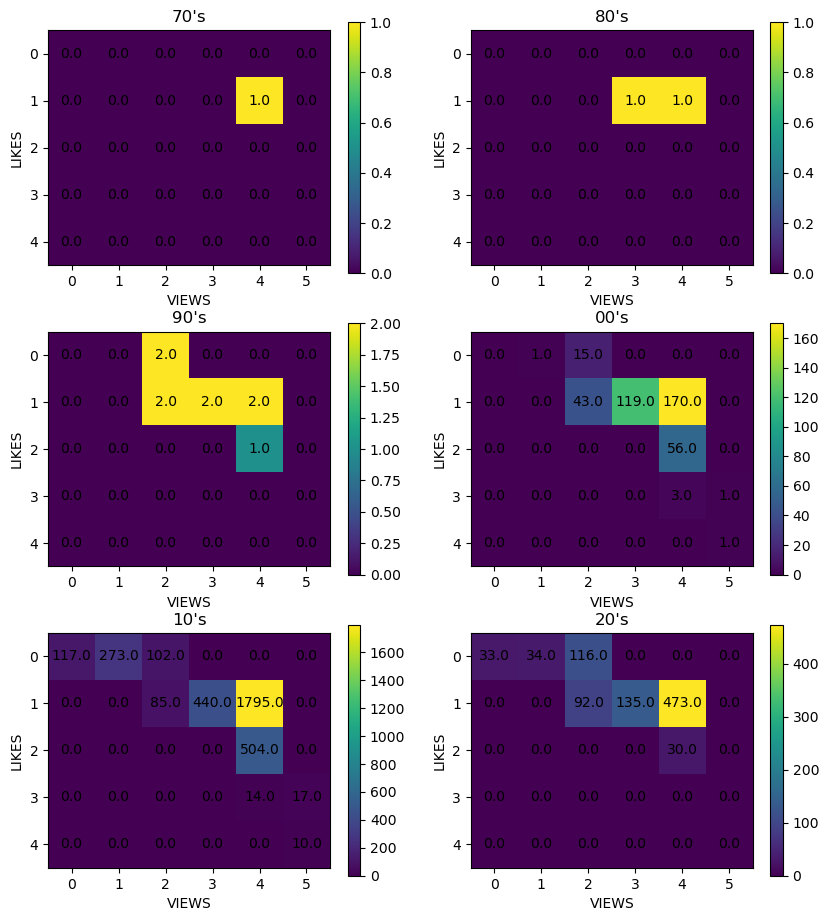

In [133]:
##OLAP che ha come dimensioni: x: le date quantizzate, y: le views quantizzate e z: il numero di like quantizzati
OLAP  = np.zeros((len(quantize_date), len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    views_class = daTed[daTed['views_quant'] == quantize_views[z]]
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_date)):
            OLAP[x,y,z] = np.sum(
                                (views_class['likes_quant'] == quantize_likes[y]) & 
                                (views_class['date_quant']  == quantize_date[x] ) )

print_all_olap_on_first_dim(OLAP, "VIEWS", "LIKES", quantize_date)

Possiamo vedere come la maggior parte dei video sia stata pubblicata nell'annata 2010-2019, e come la maggior parte dei video si trovi nella stessa classe di visualizzazioni e like, rispettivamente 1M-20M e 10K-100K. Osservando i valori medi dei dati, ha senso

In [139]:
# A TIP:
# potremmo quantizzare sulla base della deviazione standard e media in 
# "valori bassi, valori  meno della media, valori  più della media, valori  alti"
print_stats_field(daTed, 'views')
print_stats_field(daTed, 'likes') 

--------------------------------------------
Statistiche relative a:   views
--------------------------------------------
Media:                    2061575.9579044117
Moda:                     1300000
Mediana:                  1300000.0
Varianza:                 12724186465893.252
Deviazione standard:      3567097.765115676
--------------------------------------------
--------------------------------------------
Statistiche relative a:   likes
--------------------------------------------
Media:                    62607.616727941175
Moda:                     39000
Mediana:                  40500.0
Varianza:                 11587826975.425608
Deviazione standard:      107646.76946116687
--------------------------------------------


Possiamo inoltre notare un apparente correlazione fra il numero di visualizzazioni e like, meglio descritta dal seguente grafico:

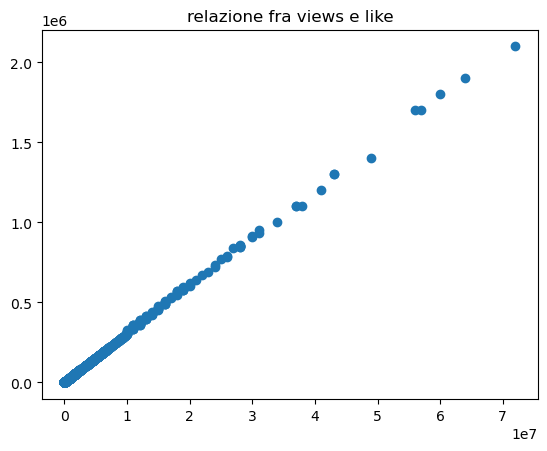

In [135]:
plt.title("relazione fra views e like")
plt.scatter(daTed["views"], daTed["likes"])

Calcolando covarianza e correlazione, la loro relazione appare ancora più ovvia

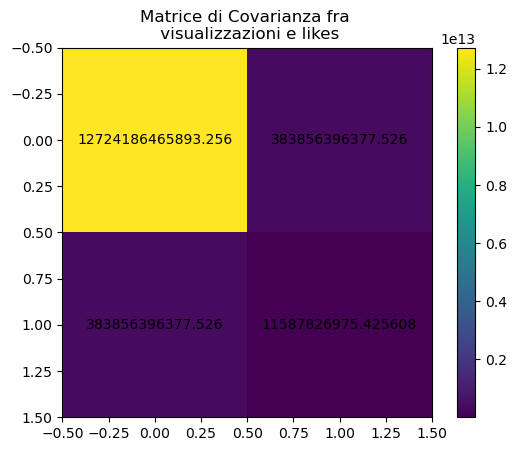

In [136]:
# matrice di covarianza

cov_matrix = daTed[["views", "likes"]].cov()
plt.imshow(cov_matrix)
plt.title("Matrice di Covarianza fra \n visualizzazioni e likes")
plt.colorbar()
for (j,i),label in np.ndenumerate(cov_matrix):
    plt.text(i,j,label,ha='center',va='center')

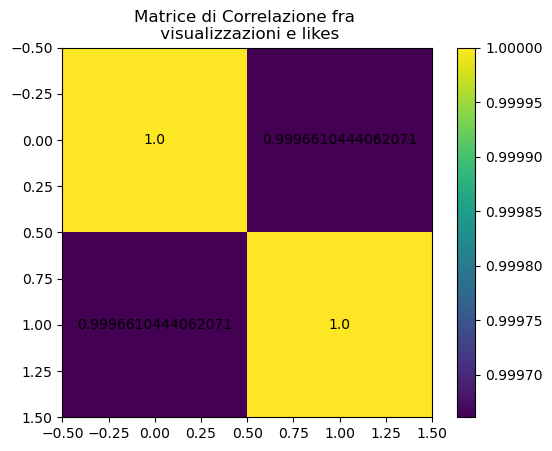

In [137]:
# matrice di correlazione

corr_matrix = daTed[["views", "likes",]].corr()
plt.title("Matrice di Correlazione fra \n visualizzazioni e likes")
plt.imshow(corr_matrix)
plt.colorbar()

for (j,i),label in np.ndenumerate(corr_matrix):
    plt.text(i,j,label,ha='center',va='center')

# 3. Test Statistici